In [1]:
#импортируем необходимые библиотеки для работы
import pandas as pd
from tqdm import tqdm
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Первичный анализ данных

In [2]:
#для того, чтобы df уместился в памяти - прочитаю даннные по chank'ам
chunks = []
for chunk in tqdm(pd.read_csv('data/train.csv',chunksize=100000,low_memory=False)):
  chunks.append(chunk)
#объединю части
train = pd.concat(chunks, ignore_index=True)

1255it [01:01, 20.39it/s]


In [3]:
#посмотрим на прочитанные данные
train.head()

id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN

In [4]:
#посмотрим на размер исходного датасета
train.shape[0]

125497040

In [5]:
#посмотрим на пропуски в столбцах
train.isna().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion    21657651
dtype: int64

In [6]:
#выделяем магазин с номерои 25, так как задание выполняется для него
df = train[train.store_nbr == 25].groupby('date')['unit_sales'].sum().reset_index()
#сохраним этот датасет отдельно, чтобы в последствии было легче его читать
df.to_csv('data/store_25.csv', index=False)
#посмотрим на данные по 25 магазину
df.head() 

date  unit_sales
0  2013-01-01    2511.619
1  2013-01-02    5316.224
2  2013-01-03    4442.913
3  2013-01-04    4844.354
4  2013-01-05    5817.526

In [8]:
df = pd.read_csv('data/store_25.csv')
df.shape

(1618, 2)

In [9]:
# приводим индексы к стандарту pd.Datetime, чтобы потом это можно было использовать seasonal_decompose
df = df.set_index(pd.DatetimeIndex(df['date']))
 # замечаем, что т.к. у нас теперь есть индекс date, нам больше не нужен столбец date, который его дублирует
df.drop(['date'], axis = 1, inplace = True)
df.head() #проверяем, что все в порядке

unit_sales
date                  
2013-01-01    2511.619
2013-01-02    5316.224
2013-01-03    4442.913
2013-01-04    4844.354
2013-01-05    5817.526

In [10]:
#устанваливаем днеувную частоту
df = df.asfreq('D')
rows_with_missing = df[df.isnull().any(axis=1)]
rows_with_missing

unit_sales
date                  
2013-12-25         NaN
2014-12-25         NaN
2015-12-25         NaN
2016-08-22         NaN
2016-08-23         NaN
...                ...
2016-10-23         NaN
2016-10-24         NaN
2016-10-25         NaN
2016-10-26         NaN
2016-12-25         NaN

[70 rows x 1 columns]

Видно, что ежегодно 25 декабря магазин не работает, потому что Рождество.  
И в период с 22.08 по 26.10 - данных нет, возможно магазин не работал или данные утеряны

In [11]:
df_filled = df.copy()
#для рождества проставлю нули
christmas_dates = [
    pd.Timestamp('2013-12-25'),
    pd.Timestamp('2014-12-25'), 
    pd.Timestamp('2015-12-25'),
    pd.Timestamp('2016-12-25')
]
print("Заполнение пропусков на Рождество нулями")
for date in tqdm(christmas_dates):
  df_filled.loc[date] = 0

#для длинного пропуска заполню средними данными за прошлые года
start  = pd.Timestamp('2016-08-22')
end = pd.Timestamp('2016-10-26')
fill_dates = pd.date_range(start=start, end=end, freq='D')
years_back=[2013, 2014, 2015]
print(f'Заполнение длинного пропуска в {len(fill_dates)} дней')
for date in tqdm(fill_dates):
  #cоздаем список для хранения значений пред. лет
  values_from_past_years = []
  for year in years_back:
    #берем дату за определенный год
    past_date = date.replace(year=year)
    #находим значение в эту дату 
    value = df_filled.loc[past_date].iloc[0]
    #добавляем значение в список
    values_from_past_years.append(value)
  #находим среднее за предыдущии года и заполняем наш год
  avg_value = np.mean(values_from_past_years)
  df_filled.loc[date] = avg_value

Заполнение пропусков на Рождество нулями


100%|██████████| 4/4 [00:00<00:00, 1334.07it/s]


Заполнение длинного пропуска в 66 дней


100%|██████████| 66/66 [00:00<00:00, 4116.10it/s]


In [12]:
df_filled.shape

(1688, 1)

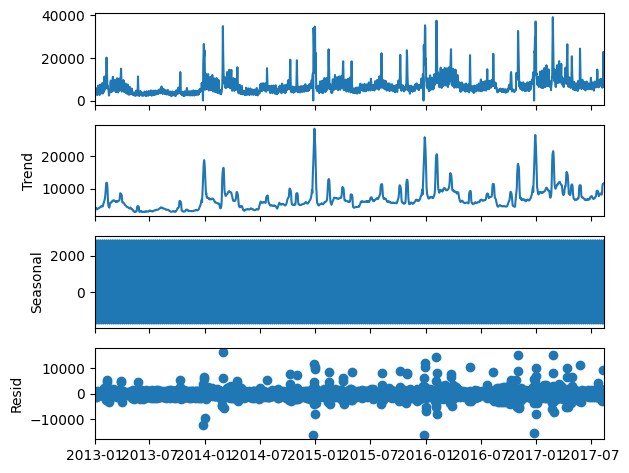

In [13]:
# применяем seasonal_decompose
# эта функция разложит ряд на трендовую, сезонную и шумовую составляющие
decomposition = seasonal_decompose(df_filled, model='additive', period=7,) 
decomposition.plot()
plt.show()

In [14]:
print(f"Исходный датасет содержит {train.shape[0]} записей")
print(f"Исходный датасет по 25 магазину содержит {df.shape[0]} записей")
print(f"После заполнения пропусков датасет по 25 магазину содержит {df_filled.shape[0]} записей")
print(f"Шумовая часть содержит {decomposition.resid.shape[0]} записей")
print(f"Шумовая часть содержит числовых {decomposition.resid.notnull().sum()} записей")
print(f"Cезонная часть содержит {decomposition.seasonal.shape[0]} записей")
print(f"Трендовая часть содержит {decomposition.trend.notnull().sum()} записей")

Исходный датасет содержит 125497040 записей
Исходный датасет по 25 магазину содержит 1688 записей
После заполнения пропусков датасет по 25 магазину содержит 1688 записей
Шумовая часть содержит 1688 записей
Шумовая часть содержит числовых 1682 записей
Cезонная часть содержит 1688 записей
Трендовая часть содержит 1682 записей


In [15]:
#проведем тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller
test = adfuller(df_filled['unit_sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -5.81464073208899
p-value:  4.3209463667836093e-07
Critical values:  {'1%': -3.4342812150354276, '5%': -2.8632764080687307, '10%': -2.5676944214132233}
ряд стационарен


## Разбиение на тренировочный и валидационный датасеты

In [16]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
for i, (train_df, test_df) in enumerate(tscv.split(df_filled.unit_sales)):
  print(f'Fold:{i}')
  print(f'Train size: {len(train)}')
  print(f'Test size: {len(test)}')

Fold:0
Train size: 125497040
Test size: 6
Fold:1
Train size: 125497040
Test size: 6
Fold:2
Train size: 125497040
Test size: 6


## "Оконные функции" временного ряда

In [17]:
#рассчитаем некоторые параметры временного ряда
df_filled['rolling_mean_5'] = df_filled.unit_sales.rolling(window=5).mean()
df_filled['rolling_std_5'] = df_filled.unit_sales.rolling(window=5).std()
df_filled['rolling_mean_30'] = df_filled.unit_sales.rolling(window=30).mean()
df_filled['rolling_std_30'] = df_filled.unit_sales.rolling(window=30).std()
df_filled['upper_bolinger'] = df_filled['rolling_mean_30']+3*df_filled['rolling_std_30']
df_filled['lower_bolinger'] = df_filled['rolling_mean_30']-3*df_filled['rolling_std_30']
df_filled['rolling_std_10'] = df_filled.unit_sales.rolling(window=10).std()
df_filled['rolling_ema_7'] = df_filled.unit_sales.ewm(min_periods=7, span=7).mean()

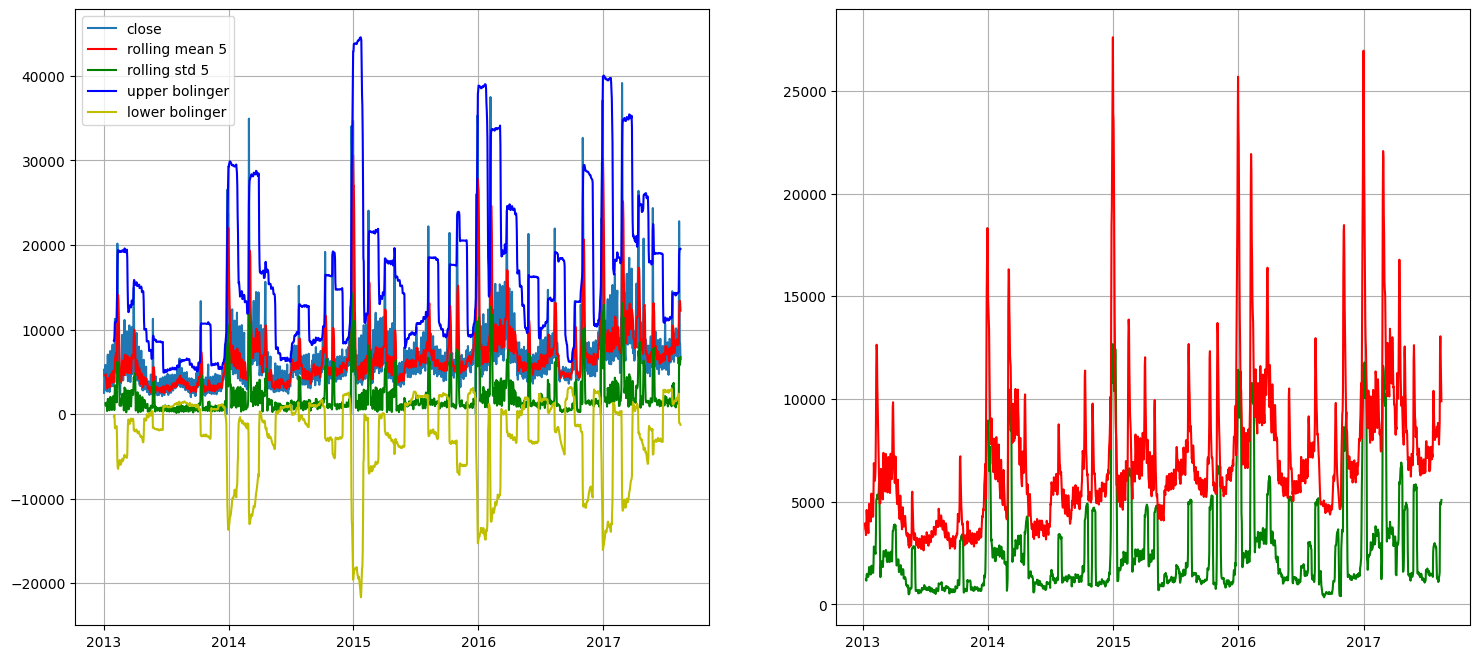

unit_sales
date                  
2013-01-01    2511.619
2013-01-02    5316.224
2013-01-03    4442.913
2013-01-04    4844.354
2013-01-05    5817.526
2013-01-06    3201.695
2013-01-07    2783.978
2013-01-08    2884.284
2013-01-09    3565.639
2013-01-10    2673.934
2013-01-11    4794.148
2013-01-12    7036.223

In [18]:
## визуализируем
f, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].plot(df_filled.index, df_filled.unit_sales) ## исходные данные
ax[0].plot(df_filled.index, df_filled.rolling_mean_5, c='r') ## оконное среднее
ax[0].plot(df_filled.index, df_filled.rolling_std_5,  c='g') ## оконный ско
ax[0].plot(df_filled.index, df_filled.upper_bolinger,  c='b') ## верхняя линия болинджера
ax[0].plot(df_filled.index, df_filled.lower_bolinger,  c='y') ## верхняя линия болинджера
ax[0].legend(['close', 'rolling mean 5', 'rolling std 5', 'upper bolinger', 'lower bolinger'])
ax[0].grid()

ax[1].plot(df_filled.index, df_filled.rolling_std_10, c='g') ## оконное стандартное отклонение
ax[1].plot(df_filled.index, df_filled.rolling_ema_7, c='r') ## экспоненциально среднее
ax[1].grid()
plt.show()

df.head(12)

In [19]:
#функция расчет среднего арифметического между максимальным и минимальным значением окна 10
def avg_max_min_10(values):
  max_window = np.max(values)
  min_window = np.min(values)
  return (max_window + min_window) / 2
#применяем функцию
df_filled['avg_min_max_10'] = df_filled.unit_sales.rolling(window=10).apply(avg_max_min_10)

df_filled['rolling_mean_50'] = df_filled.unit_sales.rolling(window=50).mean()
df_filled['rolling_ema_10'] = df_filled.unit_sales.ewm(min_periods=10, span=10).mean()
#получим индексы датафрейма, на которых одно скользящее пересекается с другим
inter_index_df = np.sign(df_filled['rolling_mean_50'] - df_filled['rolling_ema_10']).diff()
inter_index = inter_index_df[inter_index_df>0].index
inter_index

DatetimeIndex(['2013-02-20', '2013-02-26', '2013-03-05', '2013-03-11',
               '2013-03-17', '2013-03-24', '2013-04-08', '2013-05-28',
               '2013-07-01', '2013-07-08', '2013-08-27', '2013-09-02',
               '2013-10-21', '2013-11-03', '2013-12-05', '2014-01-16',
               '2014-01-19', '2014-04-01', '2014-04-20', '2014-06-09',
               '2014-06-24', '2014-08-06', '2014-09-08', '2014-09-23',
               '2014-09-25', '2014-10-20', '2014-11-07', '2014-12-02',
               '2014-12-07', '2015-01-10', '2015-02-25', '2015-03-02',
               '2015-03-10', '2015-03-16', '2015-03-23', '2015-03-30',
               '2015-04-13', '2015-05-05', '2015-07-16', '2015-07-30',
               '2015-08-19', '2015-08-23', '2015-10-20', '2015-11-09',
               '2016-01-11', '2016-02-15', '2016-02-23', '2016-02-29',
               '2016-03-06', '2016-04-05', '2016-04-10', '2016-06-06',
               '2016-07-05', '2016-07-12', '2016-08-22', '2016-10-20',
      

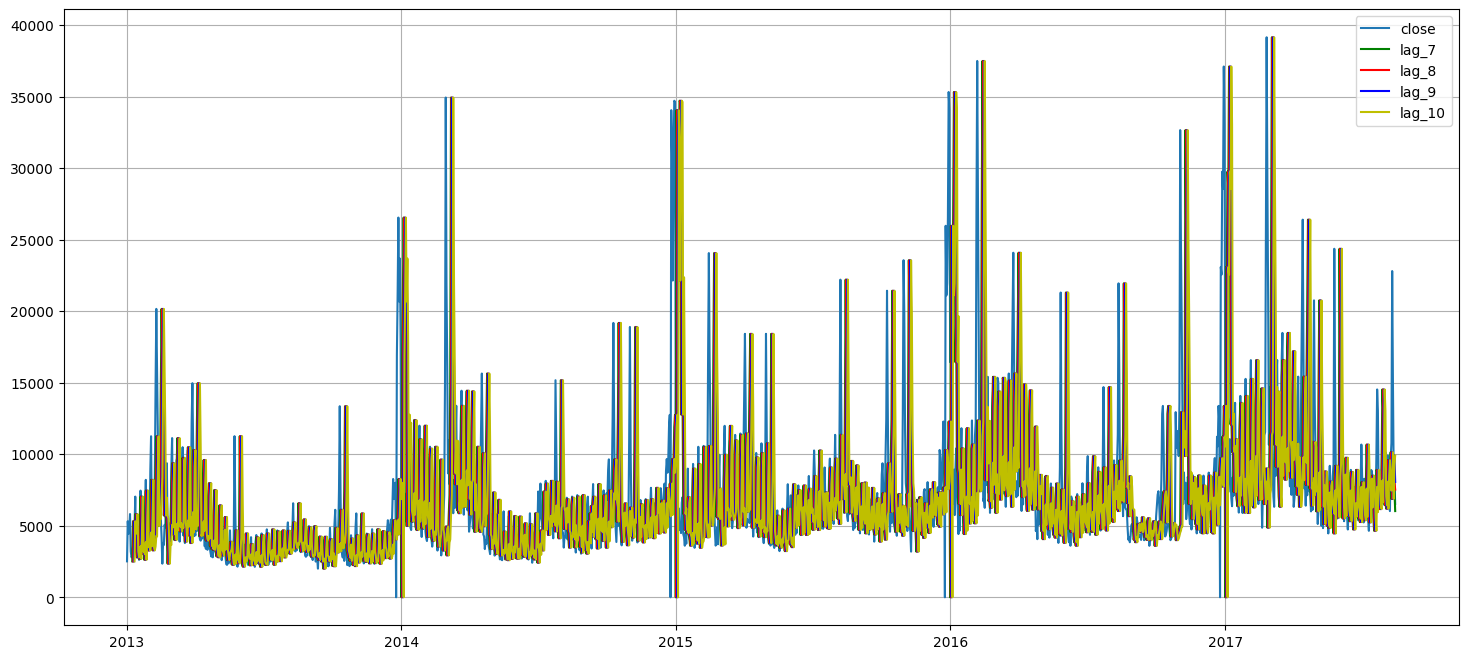

In [20]:
#получим лаги
for i in range(7,11):
    df_filled['lag_{}'.format(i)] = df_filled.unit_sales.shift(i)
    ## визуализируем
f, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(df_filled.index, df_filled.unit_sales) ## исходные данные
ax.plot(df_filled.index, df_filled['lag_' + str(7)],  c='g') 
ax.plot(df_filled.index, df_filled['lag_' + str(8)],  c='r') 
ax.plot(df_filled.index, df_filled['lag_' + str(9)],  c='b') 
ax.plot(df_filled.index, df_filled['lag_' + str(10)],  c='y') 
ax.legend(['close', 'lag_7', 'lag_8', 'lag_9', 'lag_10'])
ax.grid()

## Прогнозирование временного ряда

In [21]:
#выбираем данные по продажам конкретного товара
item_data = train[train['item_nbr']==103501].groupby('date').sum()['unit_sales'].reset_index()
#устанавливаем в качестве индекса дату
item_data = item_data.set_index(pd.DatetimeIndex(item_data['date']))
item_data = item_data.drop('date', axis=1)

In [22]:
#проведем тест на стационарность ряда
test_item = adfuller(item_data['unit_sales'])
print ('adf: ', test_item[0] )
print ('p-value: ', test_item[1])
print ('Critical values: ', test_item[4])
if test_item[0]> test_item[4]['5%']:
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.154403058014615
p-value:  0.0007863083913836471
Critical values:  {'1%': -3.4344462031760283, '5%': -2.8633492329988335, '10%': -2.5677331999518147}
ряд стационарен


(6,) (6, 1)
MSE 287.087962962963
MAE 13.416666666666666
MAPE 0.17213844967435177


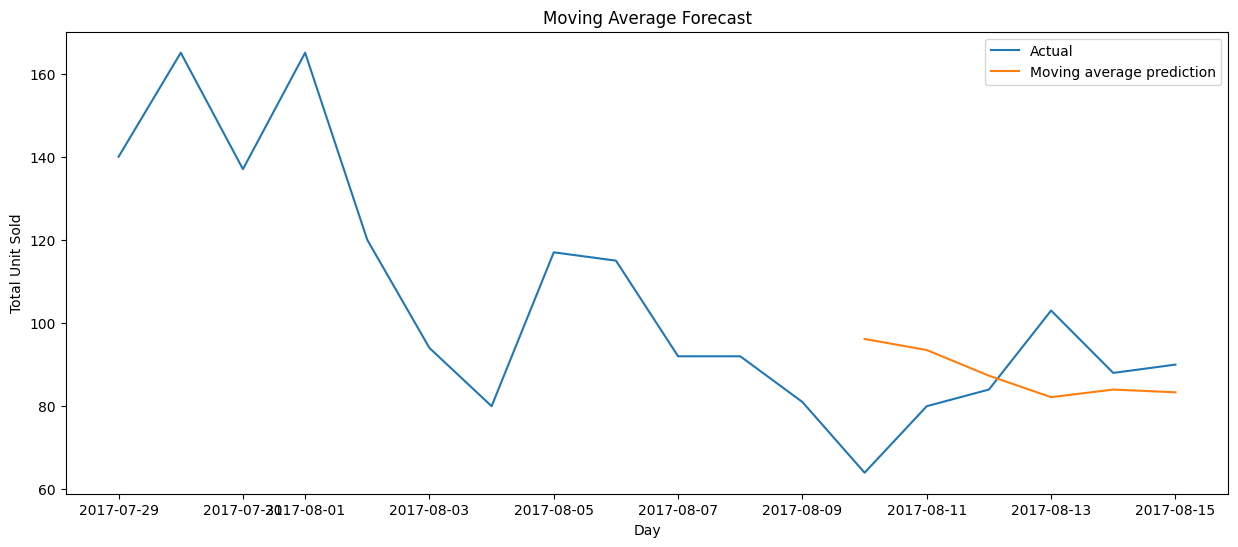

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
#посчитаем метрики с помощью прогноза на основе скользящего среднего
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)
moving_average_days = 6

shown_train_size = moving_average_days * 3
moving_avg = moving_average_forecast(item_data.values,moving_average_days )
moving_avg = pd.Series(moving_avg, index = item_data[moving_average_days:].index)

print(moving_avg[-moving_average_days:].shape,item_data[-moving_average_days:].shape)

print("MSE",mean_squared_error(item_data.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print("MAE",mean_absolute_error(item_data.values[-moving_average_days:], moving_avg[-moving_average_days:]))
print("MAPE",mean_absolute_percentage_error(item_data.values[-moving_average_days:], moving_avg[-moving_average_days:]))
plt.figure(figsize=(15,6))

plt.plot(item_data[- shown_train_size:], label="Actual")
plt.plot(moving_avg[-moving_average_days:], label="Moving average prediction")
plt.ylabel("Total Unit Sold")
plt.xlabel("Day")
plt.title("Moving Average Forecast")
plt.legend(loc="upper right")

In [24]:
#сделаем лаги с 1 по 6
#получим лаги
for i in range(1,7):
    item_data['lag_{}'.format(i)] = item_data.unit_sales.shift(i)

item_data

unit_sales  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6
date                                                            
2013-01-02       185.0    NaN    NaN    NaN    NaN    NaN    NaN
2013-01-03       153.0  185.0    NaN    NaN    NaN    NaN    NaN
2013-01-04       155.0  153.0  185.0    NaN    NaN    NaN    NaN
2013-01-05       160.0  155.0  153.0  185.0    NaN    NaN    NaN
2013-01-06       173.0  160.0  155.0  153.0  185.0    NaN    NaN
...                ...    ...    ...    ...    ...    ...    ...
2017-08-11        80.0   64.0   81.0   92.0   92.0  115.0  117.0
2017-08-12        84.0   80.0   64.0   81.0   92.0   92.0  115.0
2017-08-13       103.0   84.0   80.0   64.0   81.0   92.0   92.0
2017-08-14        88.0  103.0   84.0   80.0   64.0   81.0   92.0
2017-08-15        90.0   88.0  103.0   84.0   80.0   64.0   81.0

[1625 rows x 7 columns]

Сделаем предсказание с помощью линейной регресии

In [25]:
#отложим 2 последних дня в тестовую выборку
test_size = 7
item_data.dropna(inplace = True)
item_test = item_data.tail(test_size)
item_train = item_data[0:-test_size]
#разделим даннные для обучения линейной регресии
x_train, y_train = item_train.drop(['unit_sales'], axis=1), item_train['unit_sales']
x_test, y_test = item_test.drop(['unit_sales'], axis=1), item_test['unit_sales']

[ 0.64633423 -0.0954691  -0.00457681 -0.00092084 -0.07279466  0.31680596]
21.27708466675125
MSE AR 148.5642842085367
MAE AR 10.779290497881522
MAPE AR 0.13326534507673302


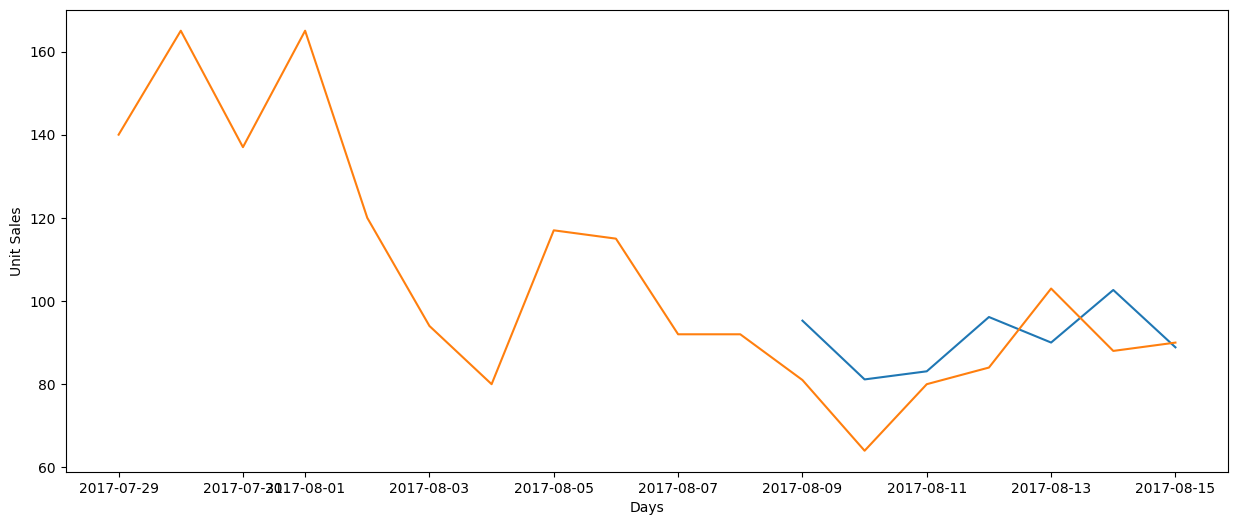

In [26]:
#Обучим линейную регрессию
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
print(reg.coef_)
print(reg.intercept_)
#сделаем предсказание
ar_predictions = pd.Series(reg.predict(x_test), index=x_test.index)
#посмотрим на графики предсказаний
plt.figure(figsize=(15,6))
plt.plot(ar_predictions ,label = "Predictions")
plt.plot(pd.concat([y_train, y_test], axis = 0)[-shown_train_size:], label = "Original" )
plt.xlabel("Days")
plt.ylabel("Unit Sales")

print("MSE AR",mean_squared_error(item_data.unit_sales[-test_size:], ar_predictions))
print("MAE AR",mean_absolute_error(item_data.unit_sales[-test_size:], ar_predictions))
print("MAPE AR",mean_absolute_percentage_error(item_data.unit_sales[-test_size:], ar_predictions))

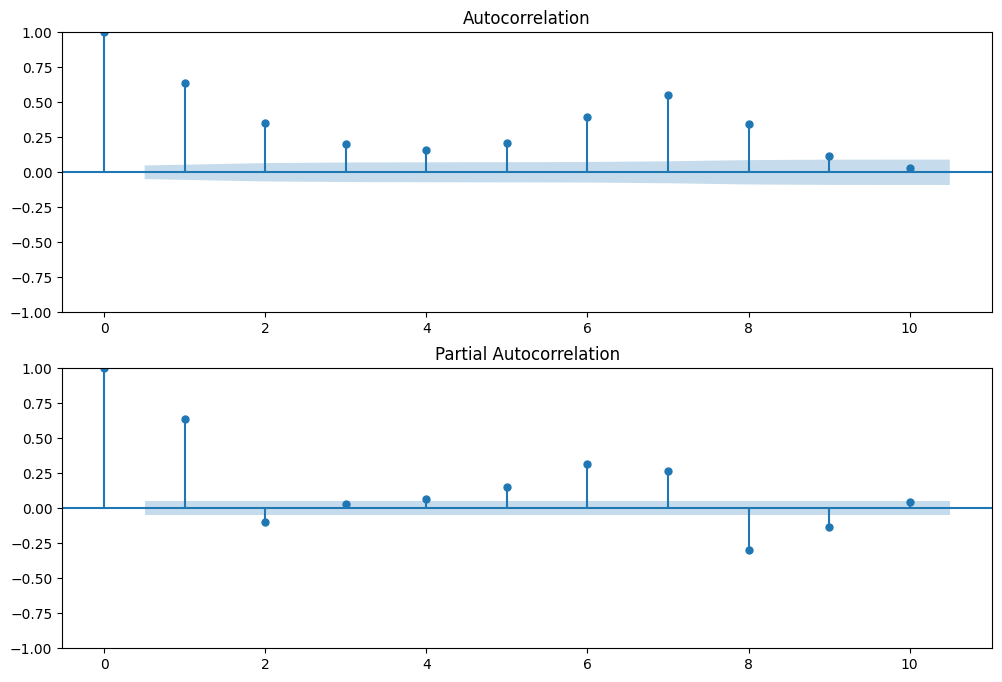

In [27]:
#построим acf и pacf для определения p и q
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(item_data.unit_sales.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(item_data.unit_sales, lags=10, ax=ax2)

1. Последнний значимый лаг 9: q = 9
2. Резкий обрыв в PACF после 1 лага: p = 1

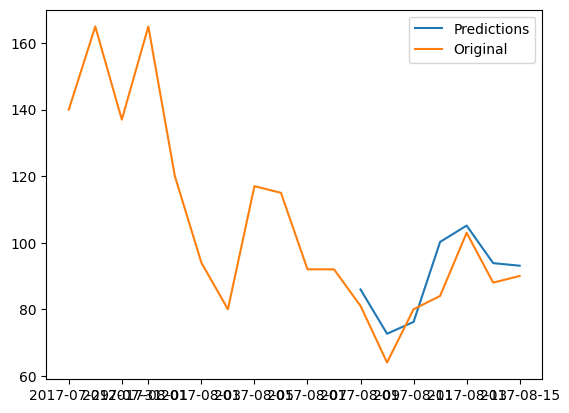

In [28]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train.values.reshape(-1), order=(9,0,1))

from statsmodels.graphics.tsaplots import plot_predict

train_size = len(y_train)
test_size = test_size
arima_predictions = model.fit().predict(start=train_size,end=train_size+test_size -1,  dynamic=False)

plt.plot(pd.Series(arima_predictions, index=y_test.index) ,label = "Predictions")
plt.plot(pd.concat([y_train, y_test], axis = 0)[-shown_train_size:], label = "Original" )
plt.legend(loc="upper right")

In [29]:
print("MSE ARIMA",mean_squared_error(item_data.unit_sales[-test_size:], arima_predictions))
print("MAE ARIMA",mean_absolute_error(item_data.unit_sales[-test_size:], arima_predictions))
print("MAPE ARIMA",mean_absolute_percentage_error(item_data.unit_sales[-test_size:], arima_predictions))

MSE ARIMA 60.81552274108484
MAE ARIMA 6.388795653770645
MAPE ARIMA 0.07980153674440185


Выводы по предсказанию: при правильно подобранных параметрах, конечно, модель ARIMA показывает гораздо лучшие предсказания чем AR.  

## Использование FPProphet

In [30]:
import plotly.offline as py
import plotly.graph_objs as go
from prophet import Prophet

In [31]:
#приведем исходный датасет к виду временного ряда
train_data = train.groupby('date')['unit_sales'].sum().reset_index()
#посмотрим на данные на графике
py.iplot([go.Scatter(
    x=train_data.date,
    y=train_data.unit_sales
)])

Хорошо заметно влияние сезонности и праздников на общий объем продаж.

In [32]:
#приведем название столбцов к виду для Prophet
train_data.columns = ['ds', 'y']
train_data

ds           y
0     2013-01-01    2511.619
1     2013-01-02  496092.418
2     2013-01-03  361429.231
3     2013-01-04  354459.677
4     2013-01-05  477350.121
...          ...         ...
1679  2017-08-11  826373.722
1680  2017-08-12  792630.535
1681  2017-08-13  865639.677
1682  2017-08-14  760922.406
1683  2017-08-15  762661.936

[1684 rows x 2 columns]

In [33]:
#сделаем прогноз на год вперед
m = Prophet()
m.fit(train_data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast

13:37:47 - cmdstanpy - INFO - Chain [1] start processing
13:37:47 - cmdstanpy - INFO - Chain [1] done processing


ds          trend     yhat_lower    yhat_upper    trend_lower  \
0    2013-01-01  334339.426295  231154.750749  5.189110e+05  334339.426295   
1    2013-01-02  334709.293401  253104.048752  5.237711e+05  334709.293401   
2    2013-01-03  335079.160506  156937.134423  4.250994e+05  335079.160506   
3    2013-01-04  335449.027612  214345.212375  4.912809e+05  335449.027612   
4    2013-01-05  335818.894717  396374.169680  6.657485e+05  335818.894717   
...         ...            ...            ...           ...            ...   
2044 2018-08-11  992940.996984  902245.133119  1.208053e+06  945597.946234   
2045 2018-08-12  993209.604459  953263.068932  1.251694e+06  945620.451193   
2046 2018-08-13  993478.211934  744311.384717  1.049557e+06  945555.512073   
2047 2018-08-14  993746.819409  710671.846276  9.969083e+05  945490.572953   
2048 2018-08-15  994015.426884  734240.725960  1.020377e+06  945580.101221   

       trend_upper  additive_terms  additive_terms_lower  \
0     3.343394e+05    43479.499358          43479.499358   
1     3.347093e+05    55521.891815          55521.891815   
2     3.350792e+05   -44092.018458         -44092.018458   
3     3.354490e+05    18980.391940          18980.391940   
4     3.358189e+05   198563.560391         198563.560391   
...            ...             ...                   ...   
2044  1.041843e+06    62507.749251          62507.749251   
2045  1.042263e+06   116406.065072         116406.065072   
2046  1.042818e+06   -92974.006407         -92974.006407   
2047  1.043422e+06  -139173.452776        -139173.452776   
2048  1.044025e+06  -113751.561151        -113751.561151   

      additive_terms_upper         weekly   weekly_lower   weekly_upper  \
0             43479.499358  -68157.975259  -68157.975259  -68157.975259   
1             55521.891815  -44199.985685  -44199.985685  -44199.985685   
2            -44092.018458 -131878.628884 -131878.628884 -131878.628884   
3             18980.391940  -57029.543451  -57029.543451  -57029.543451   
4            198563.560391  134003.543699  134003.543699  134003.543699   
...                    ...            ...            ...            ...   
2044          62507.749251  134003.543699  134003.543699  134003.543699   
2045         116406.065072  188401.664393  188401.664393  188401.664393   
2046         -92974.006407  -21139.074813  -21139.074813  -21139.074813   
2047        -139173.452776  -68157.975260  -68157.975260  -68157.975260   
2048        -113751.561151  -44199.985685  -44199.985685  -44199.985685   

             yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0     111637.474617  111637.474617  111637.474617                   0.0   
1      99721.877500   99721.877500   99721.877500                   0.0   
2      87786.610426   87786.610426   87786.610426                   0.0   
3      76009.935391   76009.935391   76009.935391                   0.0   
4      64560.016691   64560.016691   64560.016691                   0.0   
...             ...            ...            ...                   ...   
2044  -71495.794447  -71495.794447  -71495.794447                   0.0   
2045  -71995.599322  -71995.599322  -71995.599322                   0.0   
2046  -71834.931595  -71834.931595  -71834.931595                   0.0   
2047  -71015.477516  -71015.477516  -71015.477516                   0.0   
2048  -69551.575466  -69551.575466  -69551.575466                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                            0.0                         0.0  3.778189e+05  
1                            0.0                         0.0  3.902312e+05  
2                            0.0                         0.0  2.909871e+05  
3                            0.0                         0.0  3.544294e+05  
4                            0.0                         0.0  5.343825e+05  
...                          ...                         ...           ...  
2044          

In [34]:
py.iplot([
    go.Scatter(x=train_data['ds'], y=train_data['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

In [35]:
# Вычислим среднеквадратичную ошибку
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1683, 'yhat']-train_data['y'])**2)) )

RMSE: 107792.799459


In [36]:
#поэкспериментирую с коэффициентом changepoint_prior_scale
#переберу несколько значений и построю графики для каждого
for coef in [0.1, 0.4, 1, 2.5, 3]:
  print(f'changepoint_prior_scale = {coef}')
  m = Prophet(changepoint_prior_scale=coef)
  m.fit(train_data)
  future = m.make_future_dataframe(periods=365)
  forecast = m.predict(future)
  
  # Вычислим среднеквадратичную ошибку.
  print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1683, 'yhat']-train_data['y'])**2)) )
  py.iplot([
    go.Scatter(x=train_data['ds'], y=train_data['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

13:38:00 - cmdstanpy - INFO - Chain [1] start processing


changepoint_prior_scale = 0.1


13:38:01 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 103952.671365


changepoint_prior_scale = 0.4


13:38:01 - cmdstanpy - INFO - Chain [1] start processing
13:38:02 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 98972.891352


changepoint_prior_scale = 1


13:38:02 - cmdstanpy - INFO - Chain [1] start processing
13:38:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 97794.302318


changepoint_prior_scale = 2.5


13:38:03 - cmdstanpy - INFO - Chain [1] start processing
13:38:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 97438.355055


changepoint_prior_scale = 3


13:38:05 - cmdstanpy - INFO - Chain [1] start processing
13:38:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 97431.813498


При увеличении changepoint_prior_scale тренд становится слишком переобученным. Ошибкастановится меньше, но после значения 1 сильно не изменяется.

Теперь добавим в модель больше сезонности. Как мы видим, Пророк рассчитывает еженедельную и годовую сезонность. Нам не нужна ежедневная сезонность, потому что у нас нет внутридневных данных для этого случая. Достаточно просто добавить ежемесячную сезонность.

In [37]:
m = Prophet(changepoint_prior_scale=1)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(train_data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# Вычислим среднеквадратичную ошибку.
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1683, 'yhat']-train_data['y'])**2)) )
py.iplot([
    go.Scatter(x=train_data['ds'], y=train_data['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

13:38:11 - cmdstanpy - INFO - Chain [1] start processing
13:38:12 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 91233.445070


При добавлении месячной сезонности модель улучшилась, ошибка стала меньше.

Теперь добавим празники для модели и оценим предсказания.

In [38]:
holidays = pd.read_csv('data/holidays_events.csv')
holidays

date        type    locale locale_name  \
0    2012-03-02     Holiday     Local       Manta   
1    2012-04-01     Holiday  Regional    Cotopaxi   
2    2012-04-12     Holiday     Local      Cuenca   
3    2012-04-14     Holiday     Local    Libertad   
4    2012-04-21     Holiday     Local    Riobamba   
..          ...         ...       ...         ...   
345  2017-12-22  Additional  National     Ecuador   
346  2017-12-23  Additional  National     Ecuador   
347  2017-12-24  Additional  National     Ecuador   
348  2017-12-25     Holiday  National     Ecuador   
349  2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

In [39]:
holidays = holidays[holidays['transferred'] == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']
holidays

holiday          ds
0               Fundacion de Manta  2012-03-02
1    Provincializacion de Cotopaxi  2012-04-01
2              Fundacion de Cuenca  2012-04-12
3        Cantonizacion de Libertad  2012-04-14
4        Cantonizacion de Riobamba  2012-04-21
..                             ...         ...
345                      Navidad-3  2017-12-22
346                      Navidad-2  2017-12-23
347                      Navidad-1  2017-12-24
348                        Navidad  2017-12-25
349                      Navidad+1  2017-12-26

[338 rows x 2 columns]

In [40]:
m = Prophet(changepoint_prior_scale=1, holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(train_data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# Вычислим среднеквадратичную ошибку и MAPE
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:1684, 'yhat']-train_data['y'])**2)) )
print('MAPE: %f' % mean_absolute_percentage_error(forecast.loc[:1683, 'yhat'], train_data['y']))
py.iplot([
    go.Scatter(x=train_data['ds'], y=train_data['y'], name='y'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend')
])

13:38:18 - cmdstanpy - INFO - Chain [1] start processing
13:38:19 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 74430.903774
MAPE: 0.094289


Нам удалось спрогнозировать всплески на новогодний период. Модель не смогла уловить резкий скачок вниз на 1 января 2017 года, поэтому она не смогла успешно спрогнозировать 1 января 2017 года. 
Но модель хорошо предсказывает продажи на 24 декабря. А также прогнозируемый период после 15 августа 2017 года выглядит неплохо.

## Бустинги/деревья для прогнозирования временного ряда 

In [41]:
#Ипмортируем библиотеки
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from catboost import CatBoostRegressor

Отрежем данные после середины 2016 года, чтобы использовать их в качестве набора для проверки.

In [42]:
#сделаем дату индексом данных
boost_data = train_data.copy()
boost_data = boost_data.set_index(pd.DatetimeIndex(boost_data['ds']))
boost_data.drop(['ds'], axis = 1, inplace = True)
#разобьем данные на тренировочные и тестовые
split_date = '01-Jul-2016'
boost_train = boost_data.loc[boost_data.index <= split_date]
boost_test = boost_data.loc[boost_data.index > split_date]

In [43]:
boost_train

y
ds                    
2013-01-01    2511.619
2013-01-02  496092.418
2013-01-03  361429.231
2013-01-04  354459.677
2013-01-05  477350.121
...                ...
2016-06-27  684735.609
2016-06-28  596948.935
2016-06-29  632489.477
2016-06-30  554144.865
2016-07-01  857027.554

[1275 rows x 1 columns]

Создадим временные признаки от datetime

In [44]:
def create_features(df, label=None):
    """
    создаем признаки из datetime индекса
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [45]:
X_train, y_train = create_features(boost_train, label='y')
X_test, y_test = create_features(boost_test, label='y')

Инициализирую XGBoost и CatBoost и обучу их

In [46]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True) 

[0]	validation_0-rmse:164659.73151	validation_1-rmse:249307.58145
[1]	validation_0-rmse:130576.89181	validation_1-rmse:207749.60642
[2]	validation_0-rmse:108576.51122	validation_1-rmse:180954.35578
[3]	validation_0-rmse:89950.79115	validation_1-rmse:162058.77033
[4]	validation_0-rmse:77954.89221	validation_1-rmse:151956.84321
[5]	validation_0-rmse:69636.92876	validation_1-rmse:143671.20191
[6]	validation_0-rmse:65030.37474	validation_1-rmse:138265.98856
[7]	validation_0-rmse:57780.17222	validation_1-rmse:133982.17141
[8]	validation_0-rmse:52781.78534	validation_1-rmse:130978.40381
[9]	validation_0-rmse:49021.27319	validation_1-rmse:127722.03733
[10]	validation_0-rmse:46333.25435	validation_1-rmse:125909.73032
[11]	validation_0-rmse:42190.81742	validation_1-rmse:125468.26667
[12]	validation_0-rmse:39689.86263	validation_1-rmse:123852.05508
[13]	validation_0-rmse:38228.41638	validation_1-rmse:123667.57227
[14]	validation_0-rmse:36665.53877	validation_1-rmse:122838.12622
[15]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [47]:
cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

Learning rate set to 0.052901
0:	learn: 206784.4087703	test: 206784.4087703	test1: 308463.9249047	best: 308463.9249047 (0)	total: 165ms	remaining: 2m 45s
1:	learn: 199604.3204379	test: 199604.3204379	test1: 303538.3321215	best: 303538.3321215 (1)	total: 169ms	remaining: 1m 24s
2:	learn: 192508.4340227	test: 192508.4340227	test1: 298819.4086502	best: 298819.4086502 (2)	total: 172ms	remaining: 57.1s
3:	learn: 186679.6931512	test: 186679.6931512	test1: 291976.3538466	best: 291976.3538466 (3)	total: 174ms	remaining: 43.4s
4:	learn: 180386.3635191	test: 180386.3635191	test1: 286677.1390287	best: 286677.1390287 (4)	total: 178ms	remaining: 35.5s
5:	learn: 174875.0705059	test: 174875.0705059	test1: 283041.0758201	best: 283041.0758201 (5)	total: 182ms	remaining: 30.1s
6:	learn: 169979.0881844	test: 169979.0881844	test1: 277065.3816641	best: 277065.3816641 (6)	total: 186ms	remaining: 26.4s
7:	learn: 165289.5110739	test: 165289.5110739	test1: 273617.8236636	best: 273617.8236636 (7)	total: 189ms	r

Посмотрим на важность признаков, полученных в ходе обучения моделей

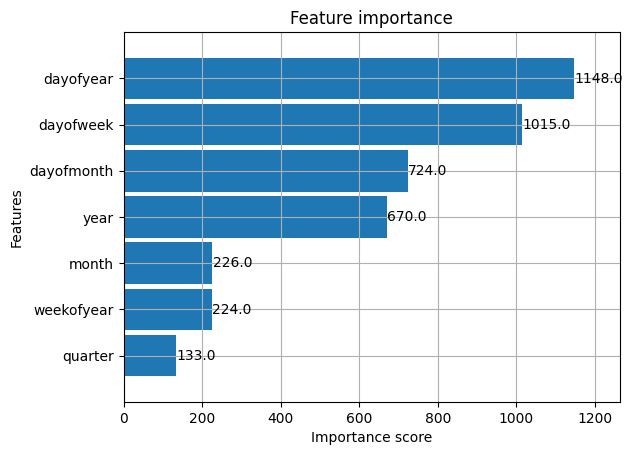

In [48]:
_ = plot_importance(reg, height=0.9)

Мы видим, что день года чаще всего использовался для разделения деревьев, а затем следуют час и год. Квартал имеет невысокую важность в связи с тем, что он мог быть создан разным разбиением по дням и годам.

Праздники тоже имеют небольшую важность.

Предсказание на тестовых данных

MAE XGB: 82868.6794388753
MAPE XGB: 0.28472509509728255
MSE XGB: 14610405949.664555
--------------------------------
MAE Cat: 111339.57660563283
MAPE Cat: 0.28229872877490136
MSE Cat: 22370814036.369347


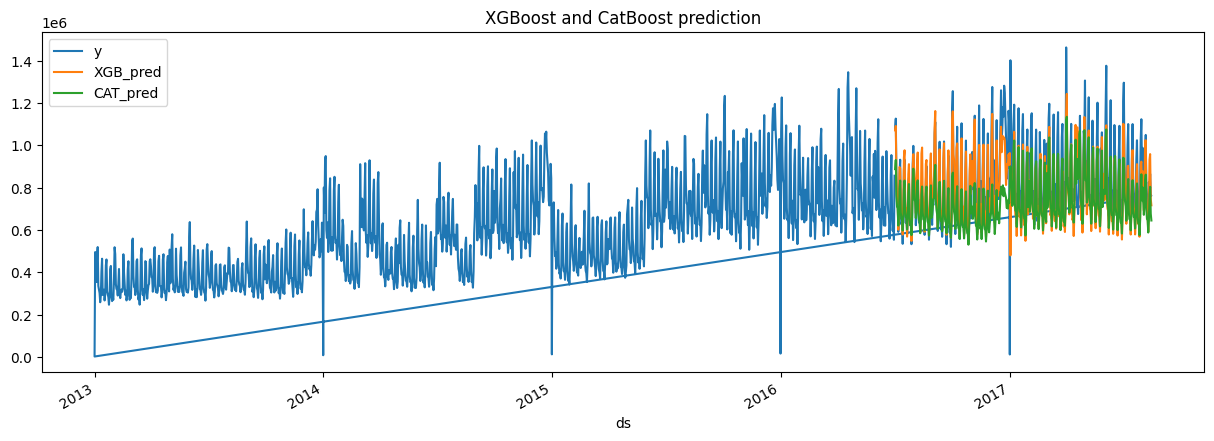

In [49]:
boost_test['XGB_pred'] = reg.predict(X_test)
boost_test['CAT_pred'] = cbr.predict(X_test)
boost_all = pd.concat([boost_test, boost_train], sort=False)

_ = boost_all[['y','XGB_pred', 'CAT_pred']].plot(figsize=(15, 5))
_.set_title('XGBoost and CatBoost prediction')

print(f'MAE XGB: {mean_absolute_error(boost_test['y'], boost_test['XGB_pred'])}')
print(f'MAPE XGB: {mean_absolute_percentage_error(boost_test['y'], boost_test['XGB_pred'])}')
print(f'MSE XGB: {mean_squared_error(boost_test['y'], boost_test['XGB_pred'])}')
print('--------------------------------')
print(f'MAE Cat: {mean_absolute_error(boost_test['y'], boost_test['CAT_pred'])}')
print(f'MAPE Cat: {mean_absolute_percentage_error(boost_test['y'], boost_test['CAT_pred'])}')
print(f'MSE Cat: {mean_squared_error(boost_test['y'], boost_test['CAT_pred'])}')

Видно, что обе модели не смогли уловить провал в начале года, да и в целом ошибка в 28% довольно-таки большая. Добавим лаги и празднничные дни

In [50]:
#Создаем функцию для добавления лагов
def add_holidays_lags(df, label):
    """
    создаем признаки прздников и лаги из datetime индекса
    """
    df['date'] = df.index
    df['is_holiday'] = df['date'].apply(lambda x: 1 if x in holidays['ds'].values else 0)
    lag_periods = [1, 2, 3, 7, 14, 30]
    for lag in lag_periods:
      df[f'lag_{lag}'] = df['y'].shift(lag)
      
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    return df


#для корректного добавления лагов применим функцию к полному датасету
#а в последствии его разделим
boost_data_new = add_holidays_lags(boost_data, 'y')

boost_train_new = boost_data.loc[boost_data_new.index <= split_date]
boost_test_new = boost_data.loc[boost_data_new.index > split_date]

In [51]:
X_train_new = boost_train_new.drop(['y','date'], axis=1)
y_train_new = boost_train_new['y']

X_test_new = boost_test_new.drop(['y', 'date'], axis=1)
y_test_new = boost_test_new['y']

X_train_new

is_holiday       lag_1       lag_2       lag_3       lag_7  \
ds                                                                       
2013-01-01           1         NaN         NaN         NaN         NaN   
2013-01-02           0    2511.619         NaN         NaN         NaN   
2013-01-03           0  496092.418    2511.619         NaN         NaN   
2013-01-04           0  361429.231  496092.418    2511.619         NaN   
2013-01-05           1  354459.677  361429.231  496092.418         NaN   
...                ...         ...         ...         ...         ...   
2016-06-27           0  954344.667  860296.835  641812.676  735754.365   
2016-06-28           0  684735.609  954344.667  860296.835  679248.022   
2016-06-29           0  596948.935  684735.609  954344.667  677730.651   
2016-06-30           0  632489.477  596948.935  684735.609  559653.337   
2016-07-01           0  554144.865  632489.477  596948.935  641812.676   

                lag_14      lag_30  hour  dayofweek  quarter  month  year  \
ds                                                                          
2013-01-01         NaN         NaN     0          1        1      1  2013   
2013-01-02         NaN         NaN     0          2        1      1  2013   
2013-01-03         NaN         NaN     0          3        1      1  2013   
2013-01-04         NaN         NaN     0          4        1      1  2013   
2013-01-05         NaN         NaN     0          5        1      1  2013   
...                ...         ...   ...        ...      ...    ...   ...   
2016-06-27  685382.193  816187.220     0          0        2      6  2016   
2016-06-28  622267.773  959853.658     0          1        2      6  2016   
2016-06-29  708327.637  752452.419     0          2        2      6  2016   
2016-06-30  620526.243  974327.990     0          3        2      6  2016   
2016-07-01  737897.438  811525.320     0          4        3      7  2016   

            dayofyear  dayofmonth  weekofyear  
ds                                             
2013-01-01          1           1           1  
2013-01-02          2           2           1  
2013-01-03          3           3           1  
2013-01-04          4           4           1  
2013-01-05          5           5           1  
...               ...         ...         ...  
2016-06-27        179          27          26  
2016-06-28        180          28          26  
2016-06-29        181          29          26  
2016-06-30        182          30          26  
2016-07-01        183           1          26  

[1275 rows x 15 columns]

Пересчитаем моделли и сделаем предсказания

In [52]:
reg_h = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg_h.fit(X_train_new, y_train_new,
        eval_set=[(X_train_new, y_train_new), (X_test_new, y_test_new)],
        verbose=True) 

[0]	validation_0-rmse:159507.76067	validation_1-rmse:246731.23692


[1]	validation_0-rmse:120904.48572	validation_1-rmse:201331.91238
[2]	validation_0-rmse:93676.43044	validation_1-rmse:173500.66135
[3]	validation_0-rmse:75014.30288	validation_1-rmse:151059.62739
[4]	validation_0-rmse:61791.02003	validation_1-rmse:136182.85678
[5]	validation_0-rmse:52879.07690	validation_1-rmse:125459.78627
[6]	validation_0-rmse:46425.24655	validation_1-rmse:120213.89006
[7]	validation_0-rmse:41280.16090	validation_1-rmse:116469.59016
[8]	validation_0-rmse:38055.63955	validation_1-rmse:113573.40625
[9]	validation_0-rmse:35587.07405	validation_1-rmse:111791.48269
[10]	validation_0-rmse:33813.82899	validation_1-rmse:110161.06895
[11]	validation_0-rmse:31478.77676	validation_1-rmse:110060.10576
[12]	validation_0-rmse:29259.89431	validation_1-rmse:109054.75917
[13]	validation_0-rmse:28232.04418	validation_1-rmse:108623.21833
[14]	validation_0-rmse:27343.79754	validation_1-rmse:107758.39812
[15]	validation_0-rmse:25886.26103	validation_1-rmse:106783.24952
[16]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

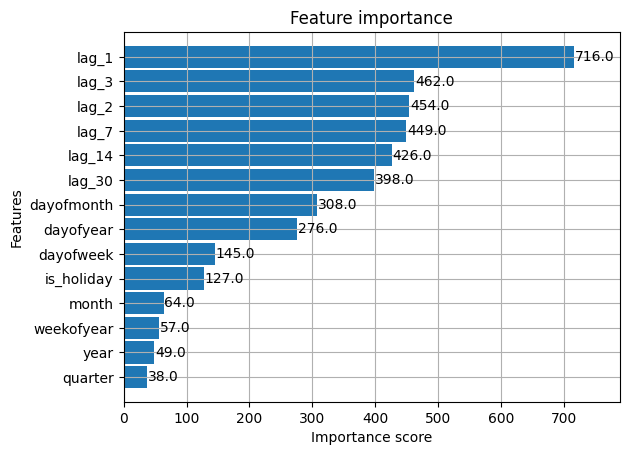

In [ ]:
_ = plot_importance(reg_h, height=0.9)

Заметно, что по важности признаков Лаги заняли первые позиции, а вот квартал, год, день недели и месяц так и остались на низах.

In [53]:
cbr_h = CatBoostRegressor(n_estimators=1000)
cbr_h.fit(X_train_new, y_train_new,
        eval_set=[(X_train_new, y_train_new), (X_test_new, y_test_new)],
        verbose=True) 

Learning rate set to 0.052901
0:	learn: 206074.1592700	test: 206074.1592700	test1: 303051.1745024	best: 303051.1745024 (0)	total: 2.89ms	remaining: 2.89s
1:	learn: 199482.1455156	test: 199482.1455156	test1: 295206.3848062	best: 295206.3848062 (1)	total: 4.66ms	remaining: 2.33s
2:	learn: 192281.7540638	test: 192281.7540638	test1: 284914.3716050	best: 284914.3716050 (2)	total: 6.69ms	remaining: 2.22s
3:	learn: 185857.1252283	test: 185857.1252283	test1: 276733.8859760	best: 276733.8859760 (3)	total: 8.63ms	remaining: 2.15s
4:	learn: 179177.5773951	test: 179177.5773951	test1: 269295.6416270	best: 269295.6416270 (4)	total: 10.1ms	remaining: 2.02s
5:	learn: 172758.3515437	test: 172758.3515437	test1: 260598.3236338	best: 260598.3236338 (5)	total: 11.9ms	remaining: 1.96s
6:	learn: 166935.2590961	test: 166935.2590961	test1: 252869.3757638	best: 252869.3757638 (6)	total: 13.6ms	remaining: 1.93s
7:	learn: 161496.4477204	test: 161496.4477204	test1: 246057.1412308	best: 246057.1412308 (7)	total: 15

MAE XGB: 69050.11634963326
MAPE XGB: 0.23741043266388046
MSE XGB: 11150825698.015549
--------------------------------
MAE Cat: 58274.79012218418
MAPE Cat: 0.2332717474069624
MSE Cat: 9627515762.856329


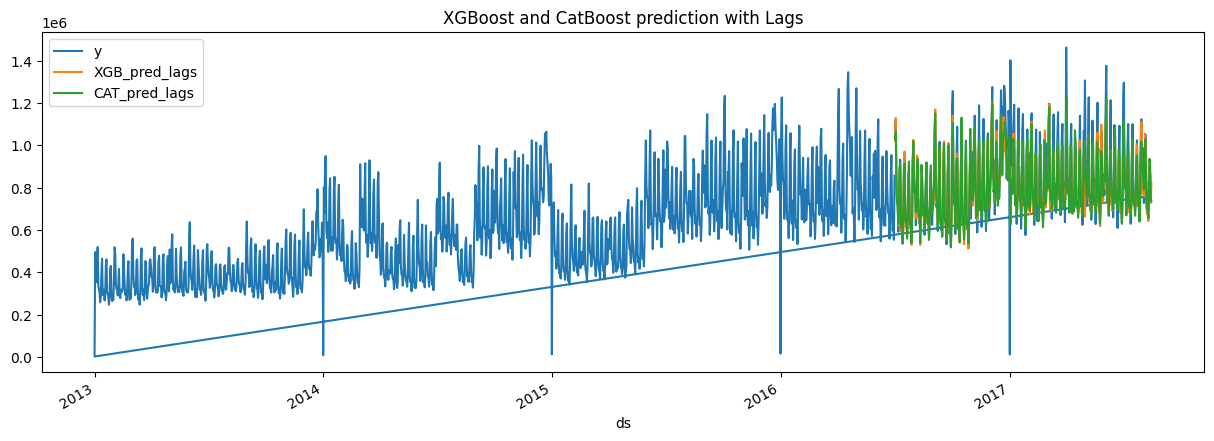

In [54]:
boost_test['XGB_pred_lags'] = reg_h.predict(X_test_new)
boost_test['CAT_pred_lags'] = cbr_h.predict(X_test_new)
boost_all = pd.concat([boost_test, boost_train], sort=False)

_ = boost_all[['y','XGB_pred_lags', 'CAT_pred_lags']].plot(figsize=(15, 5))
_.set_title('XGBoost and CatBoost prediction with Lags')

print(f'MAE XGB: {mean_absolute_error(boost_test['y'], boost_test['XGB_pred_lags'])}')
print(f'MAPE XGB: {mean_absolute_percentage_error(boost_test['y'], boost_test['XGB_pred_lags'])}')
print(f'MSE XGB: {mean_squared_error(boost_test['y'], boost_test['XGB_pred_lags'])}')
print('--------------------------------')
print(f'MAE Cat: {mean_absolute_error(boost_test['y'], boost_test['CAT_pred_lags'])}')
print(f'MAPE Cat: {mean_absolute_percentage_error(boost_test['y'], boost_test['CAT_pred_lags'])}')
print(f'MSE Cat: {mean_squared_error(boost_test['y'], boost_test['CAT_pred_lags'])}')

Даже по графику видно, что предсказания стали гораздо лучше, однако модель все еще игнорирует нулевые показатели в начале года. Применение Лагов очень сильно забустило модель. Однако модель Prophet гораздо лучше работает на тех же данных. 